# Goals

  * sentiment analysis on twitter thread interactions.
  * train a model to be able to predict conversation sentiment.

      * based on the first tweet?
      * proactive measures for dealing with customers.


In [2]:
!pip install -q kaggle
from google.colab import files 
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d thoughtvector/customer-support-on-twitter

#in drive https://drive.google.com/drive/u/1/folders/1Sh4w-8e1p2Yl_9QrAvpgRf4nmeY_KW-z

Saving kaggle.json to kaggle.json
 96% 161M/169M [00:05<00:00, 27.0MB/s]
100% 169M/169M [00:05<00:00, 33.1MB/s]


In [3]:
!pip install cloudmesh-installer
!pip install cloudmesh-common 

     |████████████████████████████████| 81kB 4.0MB/s 
     |████████████████████████████████| 81kB 4.2MB/s 
     |████████████████████████████████| 51kB 4.5MB/s 
     |████████████████████████████████| 71kB 4.3MB/s 
     |████████████████████████████████| 133kB 5.9MB/s 
     |████████████████████████████████| 870kB 6.9MB/s 
  Created wheel for python-hostlist: filename=python_hostlist-1.21-cp37-none-any.whl size=38931 sha256=fb3708425ca3f0bb7e1d5ce2355ae9a9bc4ae01503239b7a752f6a22dc45ff3c
  Stored in directory: /root/.cache/pip/wheels/0b/5b/55/ddcf52288f0b10f4564ca1b2531594ff7ccc65f487ba8dc437
  Created wheel for ordered-set: filename=ordered_set-4.0.2-py2.py3-none-any.whl size=8210 sha256=9948542c58f24a10de71b1c8dd277c44baab9f244f53b6465578e0ab399b4a3b
  Stored in directory: /root/.cache/pip/wheels/e1/c6/9b/651d8a21d59b51a75ab9c070838f9231b8126421bc0569af47
Successfully built python-hostlist ordered-set
ERROR: pytest-cov 2.11.1 has requirement coverage>=5.2.1, but you'll have coverage

## Import libraries

In [4]:
import time
from cloudmesh.common.StopWatch import StopWatch
from cloudmesh.common.Benchmark import Benchmark
from cloudmesh.common.Shell import Shell

import zipfile 

#dealing with data
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
import sklearn
from sklearn.model_selection import train_test_split

#nl libraries
import string 
import nltk #natural language tool kit
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")
nltk.download('punkt')



/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Download and reduce the data working with

In [5]:
StopWatch.start("get_data")

zfile=zipfile.ZipFile('/content/customer-support-on-twitter.zip')
data=pd.read_csv(zfile.open('twcs/twcs.csv')) 

StopWatch.stop("get_data")

print(data.shape)
data.head()

StopWatch.start("manageability")

df=data.drop(['inbound','created_at'],axis=1)
df["text"]=df["text"].astype(str)
df.sample(frac=1)
df=df.head(650) 
StopWatch.stop("manageability")


(2811774, 7)


In [18]:
StopWatch.start("removing_companies")

#companies are not anon so they have actual letters
def companies(df):
  idx=[]
  for id in range(len(df["author_id"])):
    #assuming at least one vowel in each company name
      vowels=['a','e','i','o', 'u']
      for vowel in vowels:
        if vowel in df["author_id"][id]:
          idx.append(id)
          break 
  return df.drop(idx)

#we only want the consumer side 
customers=companies(df)

StopWatch.stop("removing_companies")

# Analyze senitment for individual tweets

In [19]:
StopWatch.start("sentiment_score")

sent_analyzer=SentimentIntensityAnalyzer()

#analyze the raw tweets
customers["sentiment"]=customers["text"].apply(lambda x: sent_analyzer.polarity_scores(x)["compound"])

StopWatch.stop("sentiment_score")

# Build a new dataframe

In [40]:
# #show distribution of overall tweets and by customers
cust_average=customers.groupby("author_id")
cust_sent_average=cust_average.sentiment.mean()
cust_sent_average=pd.DataFrame({'author_id':cust_sent_average.index, 'sentiment_average': cust_sent_average.values})

#getting the first tweet for each author
customers = customers[pd.isnull(df.in_response_to_tweet_id)]

#new dataframe with the essentials
customer_first=pd.DataFrame({'author_id':customers['author_id'], 
                             'tweet':customers['text'], 
                             'first_sentiment':customers['sentiment'], 
                             'classification': 'Na'})

#add the overall sentiment binary for the entire thread
for author in customer_first['author_id']:
  sentiment=cust_sent_average.loc[cust_sent_average.author_id==author, 'sentiment_average']
  if sentiment.values < 0:
    customer_first.loc[customer_first.author_id==author,'classification'] = 0
  else:
        customer_first.loc[customer_first.author_id==author,'classification'] = 1

#add the sentiment from the first tweet sent by author
for author in customer_first['author_id']:
  sent=customer_first.loc[customer_first.author_id==author, 'first_sentiment']
  if sent.values < 0:
    customer_first.loc[customer_first.author_id==author,'first_sentiment'] = 0
  else:
        customer_first.loc[customer_first.author_id==author,'first_sentiment'] = 1

customer_first.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


,author_id,tweet,first_sentiment,classification
6,115712,@sprintcare is the worst customer service,0.0,0
12,115713,@115714 y’all lie about your “great” connectio...,0.0,0
14,115715,"@115714 whenever I contact customer support, t...",1.0,1
23,115716,actually that's a broken link you sent me and ...,0.0,0
25,115717,"Yo @Ask_Spectrum, your customer service reps a...",1.0,1


# show sentiment distribution

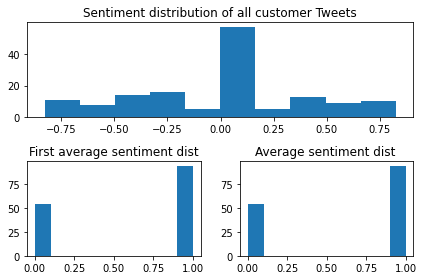

In [41]:
fig=plt.figure()

axs0=plt.subplot(211)
axs0.hist(customers["sentiment"])
axs0.set_title("Sentiment distribution of all customer Tweets")

axs1=plt.subplot(223)
axs1.hist(customer_first["first_sentiment"])
axs1.set_title("First average sentiment dist")

axs2=plt.subplot(224)
axs2.hist(customer_first["classification"])
axs2.set_title("Average sentiment dist ")


plt.tight_layout()
fig.savefig("customer_dist.png")
fig.show()


In [42]:
nltk.download('averaged_perceptron_tagger')

def encode_tweets(df):
  count=0
  encoded=[]
  embedding={}
  for scentence in df.tweet:
    encode=[]
    token=nltk.word_tokenize(scentence.lower())

    token=[ele for word_tuple in nltk.pos_tag(token) for ele in word_tuple ]

    for word in token:
      if word not in embedding:
        embedding[word]=count
        count+=1
      encode.append(embedding[word])
    encoded.append(encode)
  return (encoded)

#endoce the natural text into something the network will be able to read
encoded=encode_tweets(customer_first)

#replace the raw text with the encoded text
customer_first['tweet']=encoded

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [51]:
customer_first['tweet']=np.reshape(customer_first['tweet'].values, (-1,1))

# Dividing train and test data

In [52]:
#train test split the data should be 80 20 by default 
#fit data into the models 

#split the data into train and test subsets
train_text, test_text, train_sent, test_sent=train_test_split(customer_first['tweet'], 
                                                              customer_first['classification'])
num_classes=3

train_text=train_text.values
test_text=test_text.values

#pad the text for uniformity on length
train_text=sequence.pad_sequences(train_text, maxlen=225)
test_text=sequence.pad_sequences(test_text, maxlen=225)

train_sent=train_sent.values
test_sent=test_sent.values
train_sent=keras.utils.to_categorical(train_sent)
test_sent=keras.utils.to_categorical(test_sent)

test_text.shape



(37, 225)

# Cnn model 

In [53]:
#Cnn libraries 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from keras.layers import Conv1D, MaxPooling1D, Flatten, AveragePooling1D, Embedding
from tensorflow.keras.utils import to_categorical, plot_model

# Building the model

In [85]:
word_dict=1000000

num_labels=2
input_shape=test_text.shape
batch_size=50
kernel_size=3
pool_size=2
filters=64
dropout=0.2
epochs=10


StopWatch.start("cnn_model_building")

cnn_model=Sequential()

cnn_model.add(Embedding(word_dict, input_shape[1], input_length=input_shape[1]))

cnn_model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                activation='relu', input_shape=input_shape,
                padding='same'))
cnn_model.add(MaxPooling1D(pool_size))

cnn_model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                activation='relu', input_shape=input_shape,
                padding='same'))
cnn_model.add(MaxPooling1D(pool_size))

cnn_model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                activation='relu', input_shape=input_shape,
                padding='same'))
cnn_model.add(MaxPooling1D(pool_size))

cnn_model.add(Conv1D(filters=filters, kernel_size=kernel_size,
                activation='relu', input_shape=input_shape,
                padding='same'))
cnn_model.add(Flatten())
cnn_model.add(Dropout(dropout))
cnn_model.add(Dense(num_labels))
cnn_model.add(Activation('softmax'))
cnn_model.summary()
plot_model(cnn_model, to_file='cnn_model.png', show_shapes=True)

StopWatch.stop("cnn_model_building")

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 225, 225)          225000000 
_________________________________________________________________
conv1d_24 (Conv1D)           (None, 225, 64)           43264     
_________________________________________________________________
max_pooling1d_18 (MaxPooling (None, 112, 64)           0         
_________________________________________________________________
conv1d_25 (Conv1D)           (None, 112, 64)           12352     
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 56, 64)            0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 56, 64)            12352     
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 28, 64)           

# Compile 

In [86]:
StopWatch.start("cnn_compile")
cnn_model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
StopWatch.stop("cnn_compile")

# Model Fit

In [87]:
StopWatch.start("cnn_train")
cnn_model.fit(train_text, train_sent, batch_size=batch_size,epochs=epochs)
StopWatch.stop("cnn_train")

Epoch 1/10
3/3 [==============================] - 9s 3s/step - loss: 0.6865 - accuracy: 0.5413
Epoch 2/10
3/3 [==============================] - 7s 2s/step - loss: 0.6583 - accuracy: 0.6333
Epoch 3/10
3/3 [==============================] - 7s 2s/step - loss: 0.6473 - accuracy: 0.6308
Epoch 4/10
3/3 [==============================] - 7s 2s/step - loss: 0.6443 - accuracy: 0.6258
Epoch 5/10
3/3 [==============================] - 7s 2s/step - loss: 0.6234 - accuracy: 0.6608
Epoch 6/10
3/3 [==============================] - 7s 2s/step - loss: 0.6105 - accuracy: 0.6553
Epoch 7/10
3/3 [==============================] - 7s 2s/step - loss: 0.5949 - accuracy: 0.6478
Epoch 8/10
3/3 [==============================] - 7s 2s/step - loss: 0.5743 - accuracy: 0.6848
Epoch 9/10
3/3 [==============================] - 7s 2s/step - loss: 0.5311 - accuracy: 0.7459
Epoch 10/10
3/3 [==============================] - 7s 2s/step - loss: 0.4616 - accuracy: 0.8159


# Predicting

In [88]:
StopWatch.start("predict")

predicted=cnn_model.predict(test_text)

StopWatch.stop("predict")

# Evaluate

In [84]:
StopWatch.start("cnn_evaluate")
cnn_loss, cnn_accuracy=cnn_model.evaluate(predicted, test_sent, batch_size = batch_size)
print("CNN Accuracy: %.1f%%" %(100.0*cnn_accuracy))
StopWatch.stop("cnn_evaluate")

ValueError: ignored

In [89]:
StopWatch.benchmark()


+---------------------+------------------------------------------------------------------+
| Attribute           | Value                                                            |
|---------------------+------------------------------------------------------------------|
| BUG_REPORT_URL      | "https://bugs.launchpad.net/ubuntu/"                             |
| DISTRIB_CODENAME    | bionic                                                           |
| DISTRIB_DESCRIPTION | "Ubuntu 18.04.5 LTS"                                             |
| DISTRIB_ID          | Ubuntu                                                           |
| DISTRIB_RELEASE     | 18.04                                                            |
| HOME_URL            | "https://www.ubuntu.com/"                                        |
| ID                  | ubuntu                                                           |
| ID_LIKE             | debian                                                           